In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jun  9 07:57:18 2022

@author: mangi
"""

from pathlib import Path
import pandas as pd
from dateutil import tz
import seaborn as sns; sns.set()
from datetime import date, datetime, timezone
import matplotlib.pyplot as plt
import datetime as dt
from os import path
import math
import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages


def formatTime(timestamp, t_format, city_timezone):
    utc = datetime.fromtimestamp(timestamp, timezone.utc)
    city_timezone = tz.gettz(city_timezone)
    return utc.astimezone(city_timezone).strftime(t_format)


def time_columns(df, time__zone):

    df["Year"] = df["UNIX_UTC"].apply(formatTime, t_format = "%Y", city_timezone=time__zone)
    df["Year"] = pd.to_numeric(df["Year"], errors='coerce')
    df["Month"] = df["UNIX_UTC"].apply(formatTime, t_format = "%m", city_timezone=time__zone)
    df["Month"] = pd.to_numeric(df["Month"], errors='coerce')
    df["Day"] = df["UNIX_UTC"].apply(formatTime, t_format = "%d", city_timezone=time__zone)
    df["Day"] = pd.to_numeric(df["Day"], errors='coerce')
    df["Hour"] = df["UNIX_UTC"].apply(formatTime, t_format = "%H", city_timezone=time__zone)
    df["Hour"] = pd.to_numeric(df["Hour"], errors='coerce')
    df["Minute"] = df["UNIX_UTC"].apply(formatTime, t_format = "%M", city_timezone=time__zone)
    df["Minute"] = pd.to_numeric(df["Minute"], errors='coerce')
    df["FloatHour"] = df["Hour"]+(df["Minute"]/60)

    df['New_time'] = pd.to_datetime(df['UNIX_UTC'], unit='s')
    df = df.set_index('New_time')
    df = df.sort_index()        
    return df


def monthly_mean(i, tz):

    i = time_columns(i, tz)

    year_month = i.groupby(['Year','Month'])
    maxT = year_month['Temp'].max()
    maxT = maxT.rename("maxT")
    minT = year_month['Temp'].min()
    minT = minT.rename("minT")
    meanT = year_month['Temp'].mean()
    meanT = meanT.rename("meanT")

    return meanT, i


def check_days_with_data(i: pd.DataFrame) -> dict:
    days_counted = {}
    init = 0
    ii1 = min(i["Year"].unique())
    for ii, group in i.groupby(['Year','Month','Day']):
        i1,i2,i3 = ii
        init += 1
        if i1 > ii1:
            days_counted[i1] = init
            init = 0
            ii1 += 1
    return days_counted


def min_max(df):

    year_month_day = df.groupby(['Year','Month','Day'])

    maxT = year_month_day['Temp'].max()
    maxT = maxT.rename("maxT")
    minT = year_month_day['Temp'].min()
    minT = minT.rename("minT")
    meanT = year_month_day['Temp'].mean()
    meanT = meanT.rename("meanT")
    
    day_df = pd.concat([minT, meanT, maxT], axis=1)
    
    tropical_nights = day_df[day_df["minT"] > 20]
    tropical_nights.reset_index(inplace = True)
    no_trop_nights = tropical_nights.groupby(["Year"])["minT"].count().rename("no. tropical nights")
    hottest_night = tropical_nights.groupby(["Year"])["minT"].max().rename("hottest-night")
    heat = pd.concat([hottest_night, no_trop_nights], axis = 1)
    
    for n, value in enumerate(list(heat.index)):
        print(f"Year: {value}, No. tropical nights (>20C): {int(heat.iloc[n]['no. tropical nights'])}, hottest night: {heat.iloc[n]['hottest-night']}")
    
    return day_df


def make_datetime(row):
    return date(year=int(row['Year']), month=int(row['Month']), day=int(row['Day']))

In [2]:
directory = "/mnt/d/Dropbox/Data/weather/April 2023/"

In [3]:
# city = ["Bayonne"]
# city = ["Penvenan","Penvénan"]
# city = ["Boston"]
# city = ["Perpignan"]
# city = ["Tours"]
city = ["Helsinki"]
# city = ["Grenoble"]
# city = ["Singapore"]
# city = ["San Diego"]
timezone___ = f"Europe/{city}"
# timezone___ = f"Asia/{city}"

In [4]:
globs = []
for citi in city:
    globs1 = glob.glob(f"{directory}/**/{citi}*tab", recursive = True)
    globs2 = glob.glob(f"{directory}/**/{citi}/*tab", recursive = True)
    globs.append(globs1)
    globs.append(globs2)
globs = [x for xs in globs for x in xs]

In [5]:
globs

['/mnt/d/Dropbox/Data/weather/April 2023/Helsinki/2020.tab',
 '/mnt/d/Dropbox/Data/weather/April 2023/Helsinki/2021.tab',
 '/mnt/d/Dropbox/Data/weather/April 2023/Helsinki/2022.tab',
 '/mnt/d/Dropbox/Data/weather/April 2023/Helsinki/2023.tab']

In [6]:
dfs = []
for found_glob in globs:
        df = pd.read_csv(found_glob, delimiter = "\t", index_col=None)
        dfs.append(df)
cat_df = pd.concat(dfs)
cat_df = cat_df.drop(['Unnamed: 0'], axis = 1)
cat_df = cat_df.drop_duplicates(["City", "UNIX_UTC"])
cat_df.reset_index(inplace = True, drop = True)

cat_df["simpleTime"] = cat_df["Time"].str.split(" ", expand = True)[0]

mean_monthly_df, cat_df = monthly_mean(cat_df, timezone___)
cat_df.reset_index(inplace = True)

time_diffs = pd.DataFrame(cat_df["UNIX_UTC"].diff())
gaps = time_diffs.loc[time_diffs["UNIX_UTC"] > 86400]

In [7]:
############ SIMPLE INTERPOLATION ############

all_times = cat_df["New_time"].reindex(pd.date_range(start = cat_df["New_time"].min(), end = cat_df["New_time"].max(), freq='30min'))
all_times = pd.DataFrame(all_times)
all_times.reset_index(inplace = True)
all_times = all_times.drop(["New_time"], axis = 1)

gap_pairs = [(i-1, i) for i in gaps.index]
all_missing_times = []
for pair in gap_pairs:
    before = cat_df.iloc[list(pair)[0]]["New_time"]
    after = cat_df.iloc[list(pair)[1]]["New_time"]
    delta = after - before
    missing_timepoints = all_times.loc[(all_times["index"] > before) & (all_times["index"] < after)]
    missing_timepoints["UNIX_UTC"] = missing_timepoints['index'].astype('int64')//1e9
    all_missing_times .append ( missing_timepoints)
cat_miss_times = pd.concat(all_missing_times)
cat_miss_times = cat_miss_times.rename(columns={"index": "New_time"})
cat_miss_times = cat_miss_times.set_index(["UNIX_UTC"])
cat_df2 = cat_df.set_index(["UNIX_UTC"])

interpolated_df = pd.concat([cat_df2, cat_miss_times])
interpolated_df = interpolated_df.sort_index(ascending=True)
interpolated_df.reset_index(inplace = True)

for col in ['Min_temp', 'Max_temp', 'Temp']:
    interpolated_df[col] = interpolated_df[col].interpolate()
    # interpolated_df[col] = interpolated_df[col].interpolate(method = "time")

interpolated_df = time_columns(interpolated_df, timezone___)
interpolated_df["City"] = citi

In [8]:
############ similar time INTERPOLATION ############

cat_miss_times["no-year"] = cat_miss_times["New_time"].astype(str).str.replace(r"\d\d\d\d-", "")
cat_miss_times.reset_index(inplace=True)
cat_miss_times = time_columns(cat_miss_times, timezone___)
missing_dates = cat_miss_times[['UNIX_UTC', 'Month', 'Day', 'Hour']]

def find_other_readings(row):
    
    within_one_hour = cat_df2.loc[(cat_df2['Month'] == row["Month"]) & (cat_df2['Day'] == row["Day"]) & (cat_df2['Hour'] == row["Hour"])]
    
    row["Temp"] = within_one_hour["Temp"].mean()
    row["Max_temp"] = within_one_hour["Temp"].max()
    row["Min_temp"] = within_one_hour["Temp"].min()
    row["std"] = within_one_hour["Temp"].std()
    
    return row

gg = missing_dates.apply(find_other_readings, axis = 1)
gg.reset_index(inplace = True)
gg = gg.set_index(["UNIX_UTC"])

mean_prev_year_df = pd.concat([cat_df2, gg[['New_time','Min_temp', 'Max_temp', 'Temp']]])
mean_prev_year_df = mean_prev_year_df.sort_index(ascending=True)
mean_prev_year_df.reset_index(inplace = True)

for col in ['Min_temp', 'Max_temp', 'Temp']:
    mean_prev_year_df[col] = mean_prev_year_df[col].interpolate()

mean_prev_year_df = time_columns(mean_prev_year_df, timezone___)
mean_prev_year_df["City"] = citi

In [9]:
def plot_temperature(df):
    city = df['City'][0]
    year = df['Year'].unique()
    day_df = min_max(df)
    day_df = day_df.reset_index()
    day_df['datetime'] = day_df.apply(make_datetime, axis=1)
    
    x = day_df['datetime'].values
    y1 = day_df['minT'].values
    y2 = day_df['maxT'].values
    
    f, ax = plt.subplots(figsize=(25, 15))

    # Add background color for seasons
    for n, year in enumerate(df['Year'].unique()):
        if n+1 == len(df['Year'].unique()):
            break
        # Winter (Dec-Feb)
        start_winter = pd.to_datetime(f"{year}-12-01")
        end_winter = pd.to_datetime(f"{year+1}-02-28") if (year + 1) % 4 != 0 else pd.to_datetime(f"{year+1}-02-29")
        ax.axvspan(start_winter, end_winter, alpha=0.1, color="lightblue")

        # Spring (Mar-May)
        start_spring = pd.to_datetime(f"{year}-03-01")
        end_spring = pd.to_datetime(f"{year}-05-31")
        ax.axvspan(start_spring, end_spring, alpha=0.1, color='green')
        
        # Summer (Jun-Aug)
        start_summer = pd.to_datetime(f"{year}-06-01")
        end_summer = pd.to_datetime(f"{year}-08-31")
        ax.axvspan(start_summer, end_summer, alpha=0.1, color='red')

        # Autumn (Sep-Nov)
        start_autumn = pd.to_datetime(f"{year}-09-01")
        end_autumn = pd.to_datetime(f"{year}-11-30")
        ax.axvspan(start_autumn, end_autumn, alpha=0.1, color='orange')        
        
    plt.plot(x, y1, color = 'skyblue', linewidth=1)
    plt.plot(x, y2, color = 'darkred', linewidth=1)
    ax.fill_between(x, y1, y2, color = 'black', alpha = 0.9)

    ax.set_ylabel('Temperature (celsius)', fontsize=30)
    ax.set_xlabel('Time', fontsize=30)
    plt.xticks(rotation=90)
    plt.title(f'Daily temperature extremes for {city} {np.min(year)}-{np.max(year)}', fontsize=50)
    ax.tick_params(axis='both', which='major', labelsize=25)




Year: 2021, No. tropical nights (>20C): 1, hottest night: 24.51
Year: 2022, No. tropical nights (>20C): 2, hottest night: 20.4


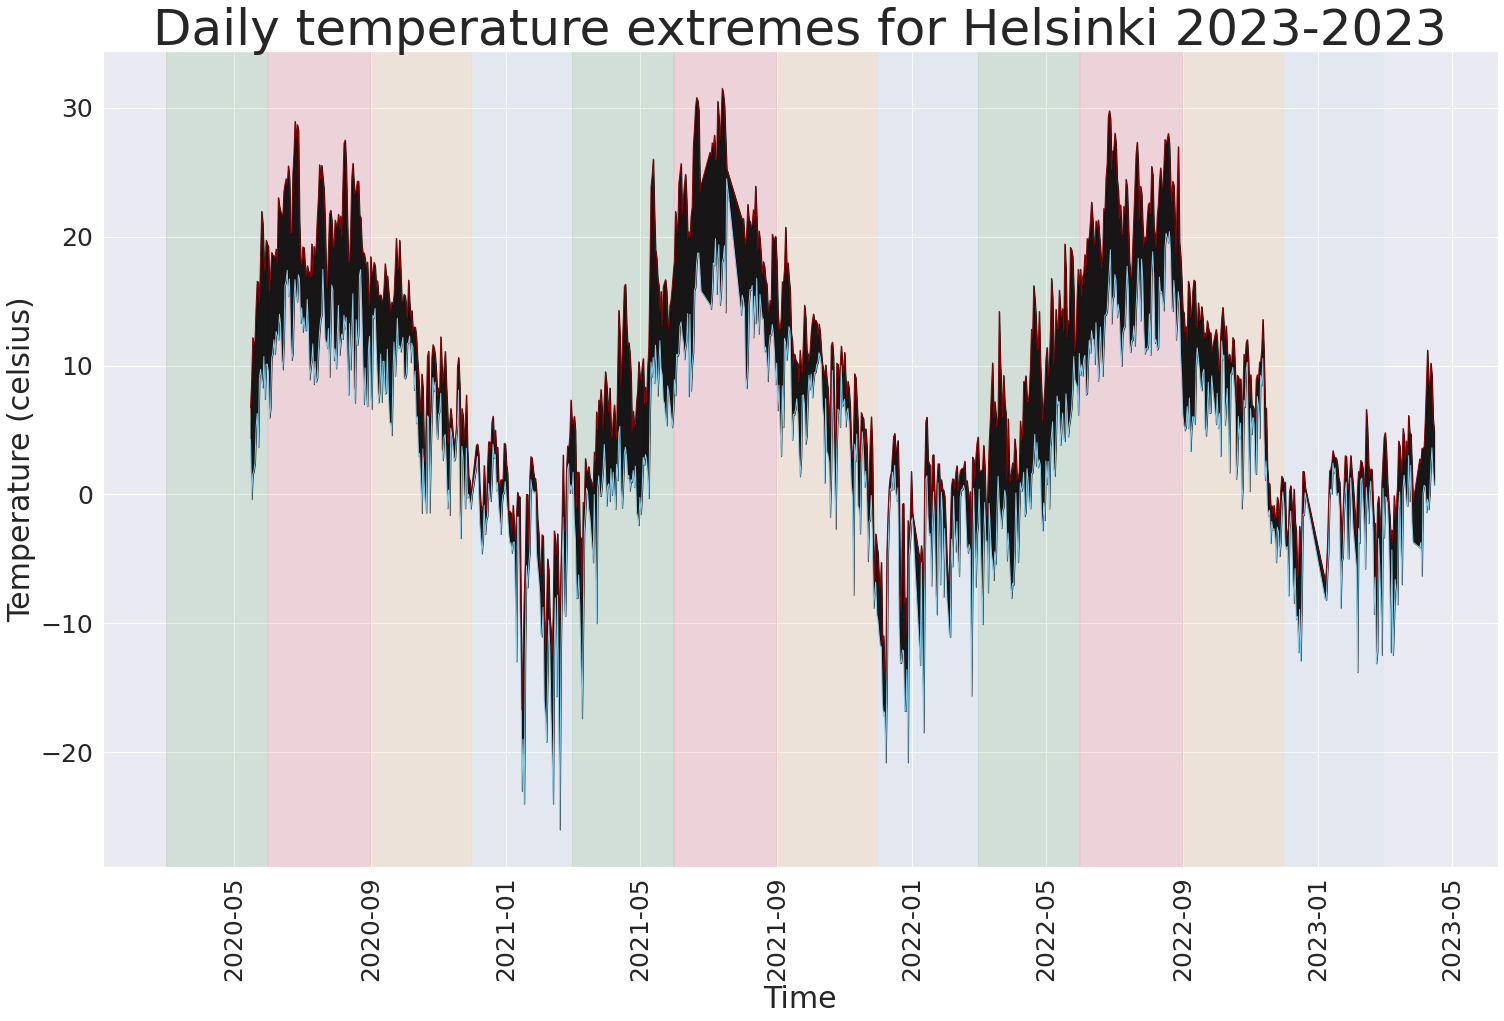

In [10]:
plot_temperature(cat_df)


Year: 2021, No. tropical nights (>20C): 8, hottest night: 23.772558139534887
Year: 2022, No. tropical nights (>20C): 2, hottest night: 20.4


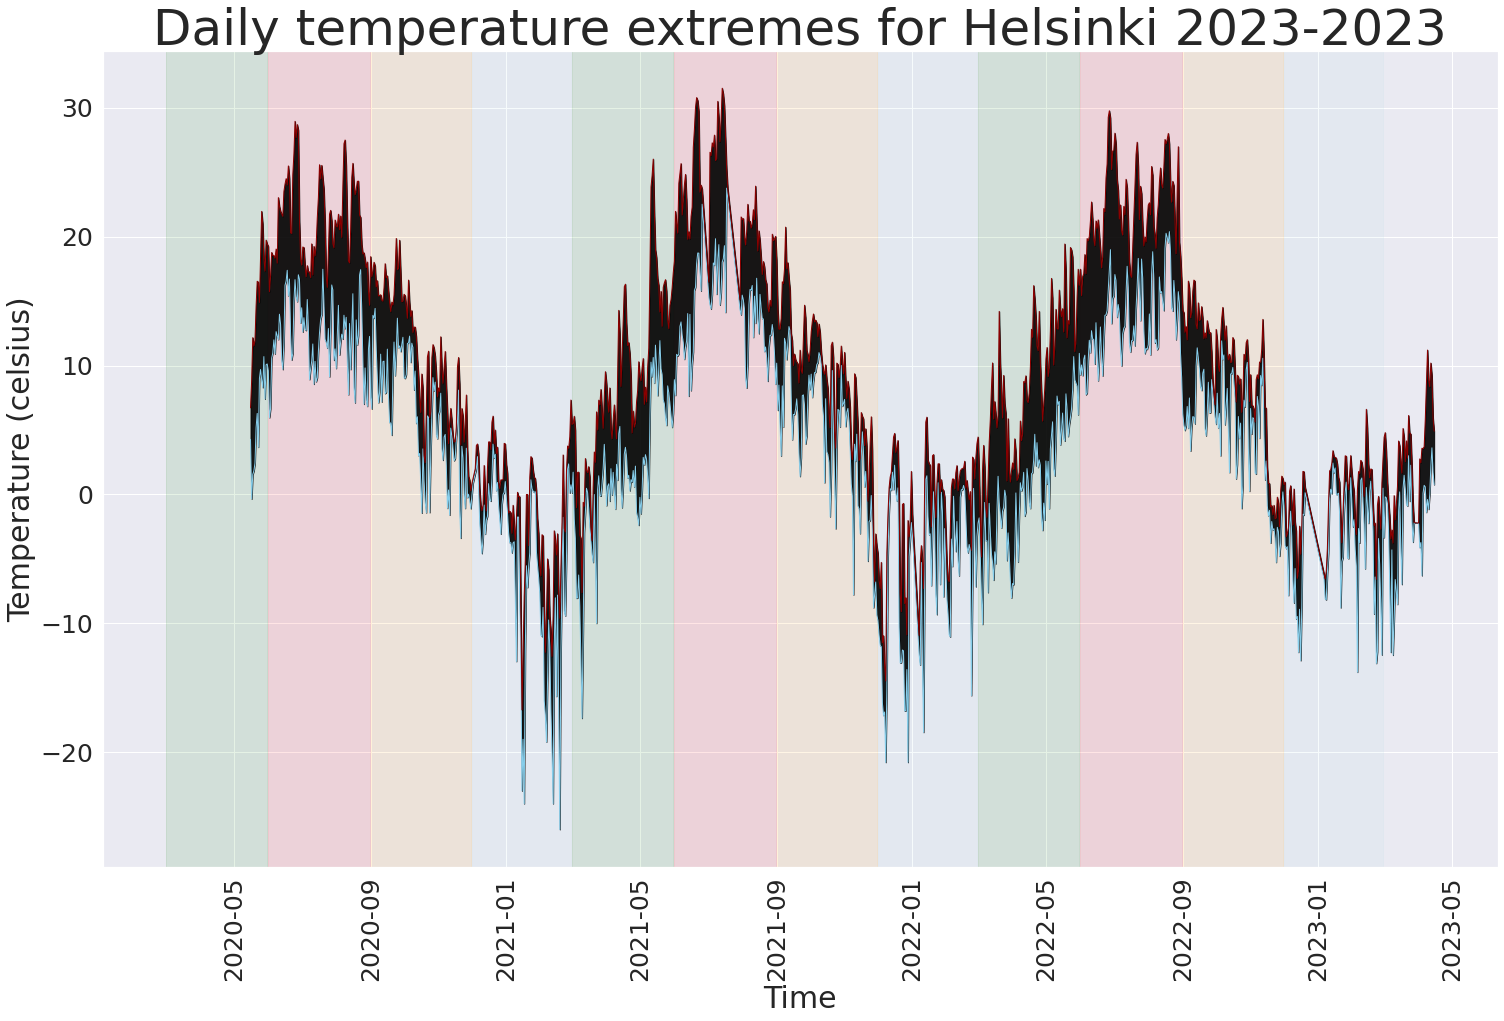

In [11]:
plot_temperature(interpolated_df)


Year: 2022, No. tropical nights (>20C): 2, hottest night: 20.4


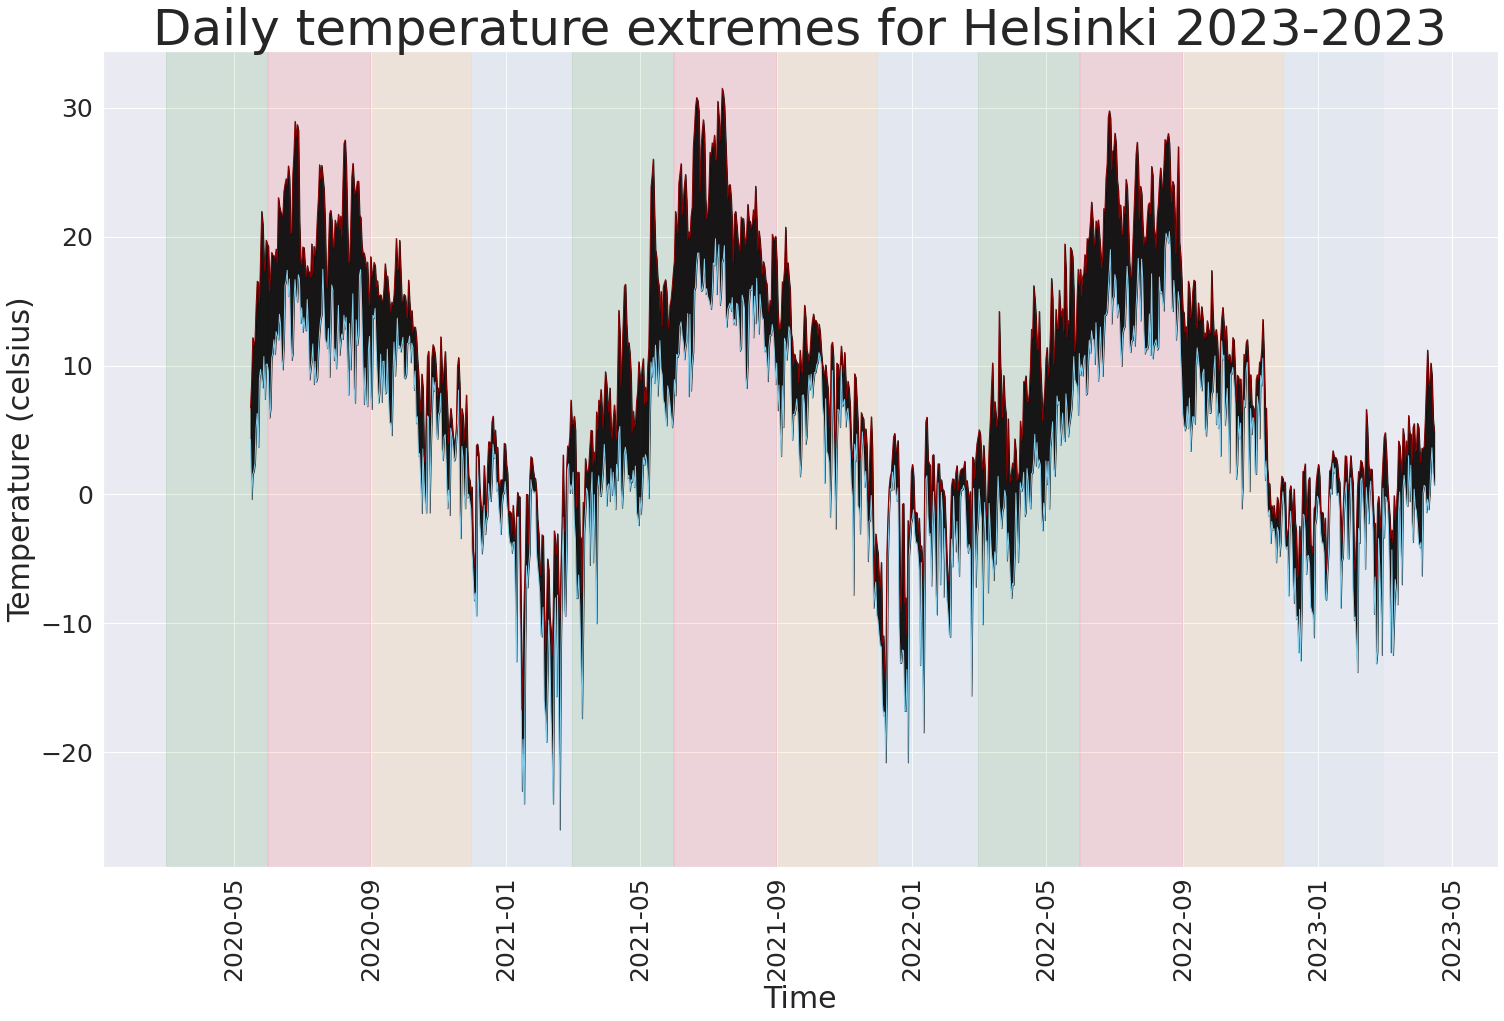

In [12]:
plot_temperature(mean_prev_year_df)